# Preprocess NDVI

Here we take our gridded NDVI data, smooth it, interpolate to daily values, summarise over the ecoregions, then save the file as a pickle file.

We can then use the pickle file for extracting phenometrics in the next notebook.

We do this because daily NDVI over Australia is a huge amount of data so it better if we only do this once and save the results.

<!-- # current_debt = 615007+42778
# lvr = 0.8
# house_value = 790000
# amount_to_pay_off = current_debt - (lvr*house_value)
# amount_to_pay_off -->

In [1]:
import sys
import dask
import pickle
import warnings
import scipy.signal
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Open a dask client

In [2]:
import sys

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask
client = start_local_dask()
client

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35955 instead
  warnings.warn

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35955/status,
Dashboard: /proxy/35955/status,Workers: 1
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44703,Workers: 1
Dashboard: /proxy/35955/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:46481,Total threads: 12
Dashboard: /proxy/36895/status,Memory: 46.00 GiB
Nanny: tcp://127.0.0.1:36635,


## Analysis Parameters


In [3]:
ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc'

# save_file = '/g/data/os22/chad_tmp/Aus_phenology/data/ecoregions_NDVI_timeseries.pkl'
# save_file = '/g/data/os22/chad_tmp/Aus_phenology/data/IBRA_regions_NDVI_timeseries.pkl'
save_file = '/g/data/os22/chad_tmp/Aus_phenology/data/IBRA_subregions_NDVI_timeseries.pkl'

# ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/Ecoregions2017_modified.geojson'
# ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_regions_modified.geojson'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'

# var='ECO_NAME'
# var='REG_NAME_7'
var='SUB_NAME_7'


## Open data

In [4]:
ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI']

## Smoothing filters

In [5]:
#resample before we smooth
ds = ds.resample(time="2W").interpolate("linear")

# # Savitsky-Golay smoothing
ds_smooth = xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=11,
            polyorder=3,
            deriv=0,
            mode='interp'),
        dask='parallelized'
    )

# ufunc reordered dims for some reason
ds_smooth = ds_smooth.transpose('time', 'latitude','longitude')

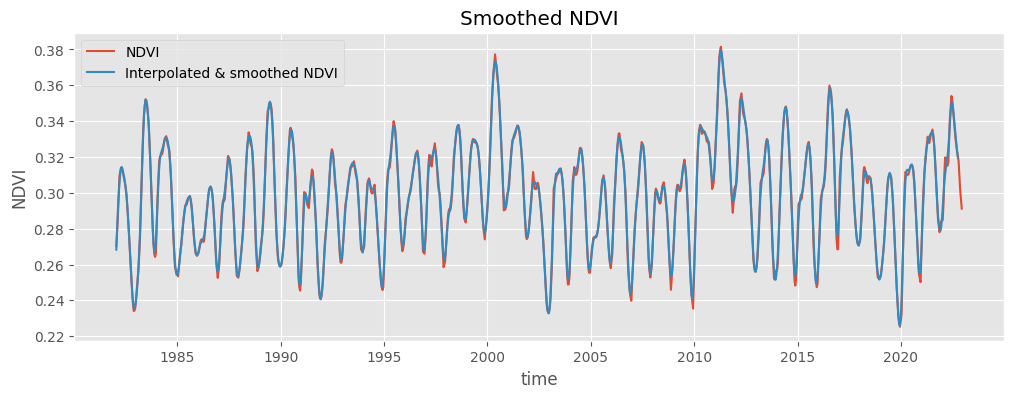

In [6]:
with plt.style.context('ggplot'):
    fig,ax=plt.subplots(1,1, figsize=(12,4))
    ds.mean(['latitude','longitude']).plot(ax=ax, label='NDVI')
    ds_smooth.mean(['latitude','longitude']).plot(ax=ax, label='Interpolated & smoothed NDVI')
    ax.legend(loc='upper left')
    ax.set_title('Smoothed NDVI');

## Save smoothed data to file

This make parallelisation with dask.delayed efficient. Each processor will read in the dataset rather than transferring the dataset across processors.

In [7]:
ds_smooth.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/NDVI_smooth.nc')

## Load ecoregions

In [8]:
gdf = gpd.read_file(ecoregions_file)

## Summarise NDVI over ecoregions

### Parallelisation version using "dask.delayed"

In [9]:
#decorate the function
@dask.delayed
def zonal_timeseries(index, ds, gdf, var):
    
    ds = assign_crs(ds, crs='EPSG:4326')
    geom = Geometry(geom=gdf.iloc[index].geometry, crs=gdf.crs)
    yy = ds.odc.mask(poly=geom)
    yy = yy.dropna(dim='longitude',
          how='all').dropna(dim='latitude', how='all')

    #summarise into 1d timeseries
    yy = yy.mean(['latitude', 'longitude'])
    
    try:
    # ---Interpolate to daily with quadratic function-------
        yy = yy.dropna(dim='time',
            how='all').resample(time='1D').interpolate(kind='quadratic')
    except:
        return np.nan
    
    return yy

#delay open datasets
path='/g/data/os22/chad_tmp/Aus_phenology/data/NDVI_smooth.nc'
dss = dask.delayed(xr.open_dataarray)(path)
gdff = dask.delayed(gpd.read_file)(ecoregions_file)

results={}
# lazily loop through polygons
for index, row in gdf.iterrows():
    zz = zonal_timeseries(index, dss, gdff, var)
    results[row[var]] = zz

In [10]:
%%time
results = dask.compute(results)[0] #bring into memory

# remove NaNs
results = {k: results[k] for k in results if not type(results[k]) is float}

distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 1min 7s, sys: 25.1 s, total: 1min 32s
Wall time: 16min 26s


## Save data

In [11]:
with open(save_file, 'wb') as f:
    pickle.dump(results, f)

### Serialised version

In [12]:
# %%time
# results={}
# i=0
# for index, row in gdf[0:20].iterrows():
#     print("Feature {:02}/{:02}\r".format(i + 1, len(range(0, len(gdf)))), end="")
    
#     #clip to ecoregion
#     geom = Geometry(geom=row.geometry, crs=gdf.crs)
#     xx = ds_smooth.odc.mask(poly=geom)
#     xx = xx.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')
    
#     # #summarise into 1d timeseries
#     xx = xx.mean(['latitude', 'longitude'])

#     #handle case where islands have no NDVI data
#     if np.isnan(xx).sum() == len(xx.time):
#         i+=1
#         continue
#     # ---Interpolate to daily with quadratic function-------
#     xx = xx.dropna(dim='time', how='all').resample(time='1D').interpolate(kind='quadratic')
    
#     results[row[var]] = xx
    
    # i+=1

## Using "multiprocess"

This works, and its fast but it was hanging at the end with only a few polygons to complete. The dask.delayed approach seems more robust, but maybe a little slower.

In [13]:
# import multiprocess as mp
# from tqdm import tqdm
# # import geopandas as gpd
# # import sys
# # from odc.geo.geom import Geometry

# def zonal_timeseries(index, var, results):
    
#     path='/g/data/os22/chad_tmp/Aus_phenology/data/NDVI_smooth.nc'
#     ds = assign_crs(xr.open_dataarray(path), crs='EPSG:4326')
#     gdff = gpd.read_file(ecoregions_file)
    
#     geom = Geometry(geom=gdff.iloc[index].geometry, crs=gdff.crs)
#     yy = ds.odc.mask(poly=geom)
#     yy = yy.dropna(dim='longitude',
#           how='all').dropna(dim='latitude', how='all')

#     #summarise into 1d timeseries
#     yy = yy.mean(['latitude', 'longitude'])
    
#     try:
#     # ---Interpolate to daily with quadratic function-------
#         yy = yy.dropna(dim='time',
#             how='all').resample(time='1D').interpolate(kind='quadratic')
        
#         results[gdff.iloc[index][var]] = yy
        
#     except:
#         results[gdff.iloc[index][var]] = np.nan

# # parallel function for above function
# def _parallel_fun(var, gdf, ncpus):

#     manager = mp.Manager()
#     results = manager.dict()

#     # progress bar
#     pbar = tqdm(total=len(gdf))

#     def update(*a):
#         pbar.update()

#     with mp.Pool(ncpus) as pool:
#         for index, row in gdf.iterrows():
#             pool.apply_async(
#                 zonal_timeseries,
#                 [index, var, results],
#                 callback=update,
#             )
                
#         pool.close()
#         pool.join()
#         pbar.close()
            
#     return results

# %%time
# results = _parallel_fun(var, gdf, ncpus=22)
# results = results._getvalue()